In [2]:
# prompt: mount my drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
# prompt: write code for unzipping

from google.colab import drive
import zipfile
import os

drive.mount('/content/drive')

# Replace with the actual path to your zip file in Google Drive
zip_file_path = '/content/drive/MyDrive/DL_Proj/archive (3).zip'
# Replace with the desired extraction directory
extract_dir = '/content/drive/MyDrive/extracted_files'

try:
  with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)
  print(f"Successfully extracted files to {extract_dir}")
except FileNotFoundError:
  print(f"Error: Zip file not found at {zip_file_path}")
except zipfile.BadZipFile:
  print(f"Error: Invalid zip file at {zip_file_path}")
except Exception as e:
  print(f"An unexpected error occurred: {e}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Successfully extracted files to /content/drive/MyDrive/extracted_files


Preprocessing train dataset...
Preprocessing validation dataset...
Preprocessing test dataset...

Verifying train dataset...
Preprocessed files count: {'VolleyballSpiking': 87, 'PushUps': 76, 'ApplyLipstick': 85, 'JumpingJack': 92, 'PullUps': 75}

Visualizing a sample from train dataset...
Loaded sample: /content/drive/MyDrive/DL_GrayScale/preprocessed_train/PushUps/v_PushUps_g18_c02.npy
Frames shape: (71, 64, 64, 1)


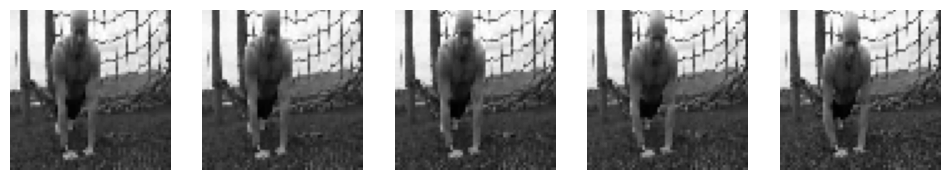

In [ ]:
import os
import cv2
import numpy as np
from multiprocessing import Pool
import matplotlib.pyplot as plt

# Directories for train, val, and test datasets on Kaggle
train_dir = '/content/drive/MyDrive/extracted_files/train'
val_dir = '/content/drive/MyDrive/extracted_files/val'
test_dir = '/content/drive/MyDrive/extracted_files/test'

# Target classes
target_classes = ['PushUps', 'JumpingJack', 'PullUps', 'VolleyballSpiking', 'ApplyLipstick']

# Preprocess video function
def preprocess_video(video_path, target_size=(64, 64), mode="GRAY"):
    """
    Preprocesses a video by resizing frames and normalizing pixel values.
    :param video_path: Path to the video file.
    :param target_size: Tuple for resizing (height, width).
    :param mode: 'RGB' or 'GRAY' for color or grayscale processing.
    :return: Array of preprocessed frames.
    """
    cap = cv2.VideoCapture(video_path)
    frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if mode == "GRAY":
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            frame = cv2.resize(frame, target_size)
            frame = frame[:, :, None]  # Add channel dimension for grayscale
        elif mode == "RGB":
            frame = cv2.resize(frame, target_size)
        else:
            raise ValueError("Invalid mode: Choose 'RGB' or 'GRAY'")
        frame = frame / 255.0  # Normalize to [0, 1]
        frames.append(frame)
    cap.release()
    return np.array(frames)

# Process a single video
def process_single_video(video_path, output_dir, class_name, mode="GRAY"):
    """
    Processes a single video and saves its preprocessed frames as an .npy file.
    :param video_path: Path to the video file.
    :param output_dir: Directory to save the preprocessed .npy files.
    :param class_name: The class of the video (e.g., 'PushUps').
    :param mode: 'RGB' or 'GRAY'.
    """
    save_dir = os.path.join(output_dir, class_name)
    os.makedirs(save_dir, exist_ok=True)
    try:
        if os.path.exists(video_path):
            frames = preprocess_video(video_path, mode=mode)
            if frames.size > 0:
                # Save as .npy file
                video_name = os.path.splitext(os.path.basename(video_path))[0]
                np.save(os.path.join(save_dir, f"{video_name}.npy"), frames)
    except Exception as e:
        print(f"Error processing {video_path}: {e}")

# Preprocess all videos in a directory
def preprocess_videos_in_dir(base_dir, output_dir, mode="GRAY", num_workers=4):
    """
    Preprocesses all videos in a directory that belong to target classes.
    :param base_dir: Base directory containing class folders.
    :param output_dir: Directory to save preprocessed videos.
    :param mode: 'RGB' or 'GRAY'.
    :param num_workers: Number of parallel workers.
    """
    videos_to_process = []
    for class_name in os.listdir(base_dir):
        class_dir = os.path.join(base_dir, class_name)
        if class_name in target_classes and os.path.isdir(class_dir):
            for video_file in os.listdir(class_dir):
                if video_file.endswith(('.avi', '.mp4')):  # Add other extensions if needed
                    videos_to_process.append((os.path.join(class_dir, video_file), output_dir, class_name, mode))

    with Pool(num_workers) as pool:
        pool.starmap(process_single_video, videos_to_process)

# Verify preprocessed files
def verify_preprocessed_files(output_dir):
    """
    Verifies the preprocessed files and prints the count of .npy files per class.
    :param output_dir: Base directory of preprocessed data.
    """
    files_summary = {}
    for class_name in os.listdir(output_dir):
        class_dir = os.path.join(output_dir, class_name)
        if os.path.isdir(class_dir):
            files_summary[class_name] = len([f for f in os.listdir(class_dir) if f.endswith('.npy')])
    print(f"Preprocessed files count: {files_summary}")

# Visualize a sample preprocessed file
def visualize_sample(output_dir, class_name):
    """
    Visualizes a few frames from a sample preprocessed .npy file.
    :param output_dir: Base directory of preprocessed data.
    :param class_name: The class to visualize (e.g., 'PushUps').
    """
    sample_dir = os.path.join(output_dir, class_name)
    sample_file = os.path.join(sample_dir, os.listdir(sample_dir)[0])  # Load first file
    frames = np.load(sample_file)
    print(f"Loaded sample: {sample_file}")
    print(f"Frames shape: {frames.shape}")

    # Display frames
    plt.figure(figsize=(12, 6))
    for i in range(min(5, len(frames))):  # Display up to 5 frames
        plt.subplot(1, 5, i + 1)
        if frames.shape[-1] == 1:  # Grayscale
            plt.imshow(frames[i, :, :, 0], cmap='gray')
        else:  # RGB
            plt.imshow(frames[i])
        plt.axis('off')
    plt.show()

# Main function to run preprocessing
def preprocess_all_datasets(train_dir, val_dir, test_dir, output_base_dir, mode="GRAY"):
    """
    Preprocess train, val, and test datasets.
    :param train_dir: Path to training dataset.
    :param val_dir: Path to validation dataset.
    :param test_dir: Path to test dataset.
    :param output_base_dir: Base directory to save preprocessed datasets.
    :param mode: 'RGB' or 'GRAY'.
    """
    output_train_dir = os.path.join(output_base_dir, "preprocessed_train")
    output_val_dir = os.path.join(output_base_dir, "preprocessed_val")
    output_test_dir = os.path.join(output_base_dir, "preprocessed_test")

    print("Preprocessing train dataset...")
    preprocess_videos_in_dir(train_dir, output_train_dir, mode=mode)
    print("Preprocessing validation dataset...")
    preprocess_videos_in_dir(val_dir, output_val_dir, mode=mode)
    print("Preprocessing test dataset...")
    preprocess_videos_in_dir(test_dir, output_test_dir, mode=mode)

    # Verify and visualize
    print("\nVerifying train dataset...")
    verify_preprocessed_files(output_train_dir)
    print("\nVisualizing a sample from train dataset...")
    visualize_sample(output_train_dir, 'PushUps')  # Change class to visualize another class

# Run the preprocessing pipeline
output_base_dir = '/content/drive/MyDrive/DL_GrayScale'
preprocess_all_datasets(train_dir, val_dir, test_dir, output_base_dir, mode="GRAY")


In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Data Generator class to load and preprocess the video data
class DataGenerator(Sequence):
    def __init__(self, preprocessed_dir, input_frames=10, output_frames=5, batch_size=4):
        self.preprocessed_dir = preprocessed_dir
        self.input_frames = input_frames
        self.output_frames = output_frames
        self.batch_size = batch_size
        self.file_list = self._get_file_list()
        self.indexes = np.arange(len(self.file_list))
        self.on_epoch_end()

    def _get_file_list(self):
        file_list = []
        for class_name in os.listdir(self.preprocessed_dir):
            class_dir = os.path.join(self.preprocessed_dir, class_name)
            if os.path.isdir(class_dir):
                for file in os.listdir(class_dir):
                    if file.endswith('.npy'):
                        file_list.append(os.path.join(class_dir, file))
        return file_list

    def __len__(self):
        return int(np.floor(len(self.file_list) / self.batch_size))

    def on_epoch_end(self):
        np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        X_batch, Y_batch = [], []
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        for idx in batch_indexes:
            file = self.file_list[idx]
            video_data = np.load(file)
            if video_data.max() > 1.0:
                video_data = video_data / 255.0
            total_frames = len(video_data)
            max_start_idx = total_frames - self.input_frames - self.output_frames
            if max_start_idx <= 0:
                continue
            start_idx = np.random.randint(0, max_start_idx + 1)
            X = video_data[start_idx:start_idx + self.input_frames]
            Y = video_data[start_idx + self.input_frames:start_idx + self.input_frames + self.output_frames]
            X_batch.append(X)
            Y_batch.append(Y)
        return np.array(X_batch), np.array(Y_batch)

# Vision Transformer Encoder
def transformer_encoder(inputs, num_heads, ff_dim, dropout=0.1):
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    attention_output = layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=inputs.shape[-1], dropout=dropout
    )(x, x)
    x = layers.Add()([inputs, attention_output])
    x = layers.Dropout(dropout)(x)

    x2 = layers.LayerNormalization(epsilon=1e-6)(x)
    ffn_output = layers.Dense(ff_dim, activation='relu')(x2)
    ffn_output = layers.Dropout(dropout)(ffn_output)
    ffn_output = layers.Dense(inputs.shape[-1])(ffn_output)
    x = layers.Add()([x, ffn_output])
    return layers.Dropout(dropout)(x)

# Residual Block for feature refinement
class ResidualBlock(layers.Layer):
    def __init__(self, filters, kernel_size=3, **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.conv1 = layers.Conv2D(filters, kernel_size, padding='same')
        self.bn1 = layers.BatchNormalization()
        self.relu1 = layers.ReLU()
        self.conv2 = layers.Conv2D(filters, kernel_size, padding='same')
        self.bn2 = layers.BatchNormalization()
        self.relu2 = layers.ReLU()
        self.add = layers.Add()
        self.skip_connection = None

    def build(self, input_shape):
        if input_shape[-1] != self.filters:
            self.skip_connection = layers.Conv2D(self.filters, 1, padding='same')
        super(ResidualBlock, self).build(input_shape)

    def call(self, inputs, training=None):
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x, training=training)

        if self.skip_connection is not None:
            inputs = self.skip_connection(inputs)

        x = self.add([inputs, x])
        return self.relu2(x)

    def compute_output_shape(self, input_shape):
        # Compute the output shape for a residual block
        height, width = input_shape[1], input_shape[2]
        return (input_shape[0], height, width, self.filters)  # Return with modified number of filters


# Vision Transformer Model for Video Prediction
def build_vit_video_model(input_frames, output_frames, img_size=(64, 64), channels=1, d_model=256, num_heads=8, num_layers=3, ff_dim=512, dropout_rate=0.1):
    inputs = layers.Input(shape=(input_frames, img_size[0], img_size[1], channels))

    # TimeDistributed Convolution + Residual Blocks
    x = layers.TimeDistributed(layers.Conv2D(64, (7, 7), strides=1, padding='same'))(inputs)
    x = layers.TimeDistributed(layers.BatchNormalization())(x)
    x = layers.TimeDistributed(layers.ReLU())(x)

    for _ in range(2):
        res_block = ResidualBlock(64)
        x = layers.TimeDistributed(res_block)(x)

    x = layers.TimeDistributed(layers.Conv2D(128, (3, 3), strides=2, padding='same'))(x)
    x = layers.TimeDistributed(layers.BatchNormalization())(x)
    x = layers.TimeDistributed(layers.ReLU())(x)

    for _ in range(2):
        res_block = ResidualBlock(128)
        x = layers.TimeDistributed(res_block)(x)

    x = layers.TimeDistributed(layers.Flatten())(x)
    x = layers.TimeDistributed(layers.Dense(d_model))(x)

    # Positional Encoding
    positions = tf.range(start=0, limit=input_frames, delta=1)
    pos_encoding = layers.Embedding(input_dim=input_frames, output_dim=d_model)(positions)
    x = layers.Add()([x, tf.expand_dims(pos_encoding, 0)] )

    # Transformer Encoders
    for _ in range(num_layers):
        x = transformer_encoder(x, num_heads, ff_dim, dropout_rate)

    # Decoder: Frame Generation
    outputs = []
    decoder_input = x[:, -1:, :]

    for _ in range(output_frames):
        y = decoder_input
        y = layers.LayerNormalization(epsilon=1e-6)(y)

        y = layers.Dense(d_model * 2, activation='relu')(y)
        y = layers.Dropout(dropout_rate)(y)
        y = layers.Dense(32 * 32 * 128)(y)

        y = layers.Reshape((-1, 32, 32, 128))(y)

        y = layers.Conv2DTranspose(64, (4, 4), strides=2, padding='same')(y[:, 0])
        y = layers.BatchNormalization()(y)
        y = layers.ReLU()(y)

        res_block = ResidualBlock(64)
        y = res_block(y)

        y = layers.Conv2D(channels, (7, 7), activation='sigmoid', padding='same')(y)

        y = layers.Lambda(lambda z: tf.expand_dims(z, axis=1))(y)
        outputs.append(y)

        decoder_input = layers.Dense(d_model)(layers.Flatten()(y[:, 0]))
        decoder_input = layers.Lambda(lambda z: tf.expand_dims(z, axis=1))(decoder_input)

    outputs = layers.Concatenate(axis=1)(outputs)

    model = models.Model(inputs=inputs, outputs=outputs)

    def custom_loss(y_true, y_pred):
        mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))
        return mse_loss

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss=custom_loss,
        metrics=['mse']
    )

    return model

# Training parameters
input_frames = 10
output_frames = 5
img_height, img_width, channels = 64, 64, 1  # Grayscale image has 1 channel
batch_size = 4
epochs = 20

# Directory for preprocessed data
preprocessed_train_dir = '/content/drive/MyDrive/DL_GrayScale/preprocessed_train'
preprocessed_val_dir = '/content/drive/MyDrive/DL_GrayScale/preprocessed_val'

# Initialize data generators
train_gen = DataGenerator(preprocessed_train_dir, input_frames, output_frames, batch_size)
val_gen = DataGenerator(preprocessed_val_dir, input_frames, output_frames, batch_size)

# Build and train the model
model = build_vit_video_model(input_frames, output_frames, img_size=(img_height, img_width), channels=channels)

# Callbacks for model saving and early stopping
callbacks = [
    ModelCheckpoint('vit_video_model.keras', save_best_only=True, monitor='val_loss'),
    EarlyStopping(patience=7, monitor='val_loss', restore_best_weights=True)
]

# Train the model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs,
    callbacks=callbacks
)

# Save the final model
model.save('final_vit_video_model.keras')

print("Model training complete and saved.")


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


103/103 ━━━━━━━━━━━━━━━━━━━━ 467s 3s/step - loss: 0.0860 - mse: 0.0860 - val_loss: 0.0785 - val_mse: 0.0785
Epoch 2/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 26s 242ms/step - loss: 0.0601 - mse: 0.0601 - val_loss: 0.0918 - val_mse: 0.0918
Epoch 3/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 25s 236ms/step - loss: 0.0535 - mse: 0.0535 - val_loss: 0.0875 - val_mse: 0.0875
Epoch 4/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 25s 237ms/step - loss: 0.0536 - mse: 0.0536 - val_loss: 0.0869 - val_mse: 0.0869
Epoch 5/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 413s 4s/step - loss: 0.0526 - mse: 0.0526 - val_loss: 0.0568 - val_mse: 0.0568
Epoch 6/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 337s 3s/step - loss: 0.0501 - mse: 0.0501 - val_loss: 0.0495 - val_mse: 0.0495
Epoch 7/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 27s 247ms/step - loss: 0.0455 - mse: 0.0455 - val_loss: 0.0502 - val_mse: 0.0502
Epoch 8/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 464s 5s/step - loss: 0.0450 - mse: 0.0450 - val_loss: 0.0489 - val_mse: 0.0489
Epoch 9/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 513s 5s/ste

In [8]:
import matplotlib.pyplot as plt
def visualize_vit_predictions(model, test_gen_viz, input_frames, output_frames, batch_size=1):
    """
    Visualizes predictions for the Vision Transformer model.
    """
    try:
        for i in range(batch_size):
            # Fetch a test sample
            X_test, Y_true = test_gen_viz[i]

            print(f"X_test shape: {X_test.shape}")  # Expected: (1, 10, 64, 64, 1)
            print(f"Y_true shape: {Y_true.shape}")  # Expected: (1, 5, 64, 64, 1)

            # Predict frames
            Y_pred = model.predict(X_test)
            print(f"Y_pred shape: {Y_pred.shape}")  # Expected: (1, 5, 64, 64, 1)

            # Extract the first sample
            X_sample = X_test[0]       # Shape: (10, 64, 64, 1)
            Y_true_sample = Y_true[0] # Shape: (5, 64, 64, 1)
            Y_pred_sample = Y_pred[0] # Shape: (5, 64, 64, 1)

            plt.figure(figsize=(20, 10))
            total_frames = input_frames + output_frames

            # Plot input frames
            for j in range(input_frames):
                plt.subplot(3, total_frames, j + 1)
                plt.imshow(X_sample[j].squeeze(), cmap='gray')
                plt.axis('off')
                if j == input_frames // 2:
                    plt.title("Input Frames")

            # Plot ground truth frames
            for j in range(output_frames):
                plt.subplot(3, total_frames, total_frames + j + 1)
                plt.imshow(Y_true_sample[j].squeeze(), cmap='gray')
                plt.axis('off')
                if j == output_frames // 2:
                    plt.title("Ground Truth")

            # Plot predicted frames
            for j in range(output_frames):
                plt.subplot(3, total_frames, 2 * total_frames + j + 1)
                plt.imshow(Y_pred_sample[j].squeeze(), cmap='gray')
                plt.axis('off')
                if j == output_frames // 2:
                    plt.title("Predicted Frames")

            plt.tight_layout()
            plt.show()

    except Exception as e:
        print("Error during visualization:", e)


In [9]:
from skimage.metrics import structural_similarity as ssim

def evaluate_vit_ssim(model, test_gen, input_frames, output_frames):
    """
    Computes the average SSIM for the Vision Transformer model.
    """
    # Predict all test samples at once
    Y_preds = model.predict(test_gen, steps=len(test_gen), verbose=0)

    # Collect all true frames
    Y_trues = []
    for i in range(len(test_gen)):
        _, Y = test_gen[i]
        Y_trues.append(Y)
    Y_trues = np.concatenate(Y_trues, axis=0)

    # Check if shapes match
    if Y_preds.shape != Y_trues.shape:
        print(f"Shape mismatch: Y_preds shape {Y_preds.shape}, Y_trues shape {Y_trues.shape}")
        return None

    total_ssim = 0
    total_frames = Y_trues.shape[0] * Y_trues.shape[1]

    for b in range(Y_trues.shape[0]):
        for t in range(Y_trues.shape[1]):
            true_frame = Y_trues[b, t].squeeze()
            pred_frame = Y_preds[b, t].squeeze()

            # Compute SSIM for grayscale frames
            ssim_val = ssim(true_frame, pred_frame, data_range=1.0)
            total_ssim += ssim_val

    avg_ssim = total_ssim / total_frames
    print(f"Average SSIM across the test set: {avg_ssim:.4f}")
    return avg_ssim


In [10]:
# Initialize Data Generator for Visualization
preprocessed_test_dir="/content/drive/MyDrive/DL_GrayScale/preprocessed_test"
test_gen_viz = DataGenerator(
    preprocessed_dir=preprocessed_test_dir,
    input_frames=input_frames,
    output_frames=output_frames,
    batch_size=1
)


Visualizing Vision Transformer predictions...
X_test shape: (1, 10, 64, 64, 1)
Y_true shape: (1, 5, 64, 64, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Y_pred shape: (1, 5, 64, 64, 1)


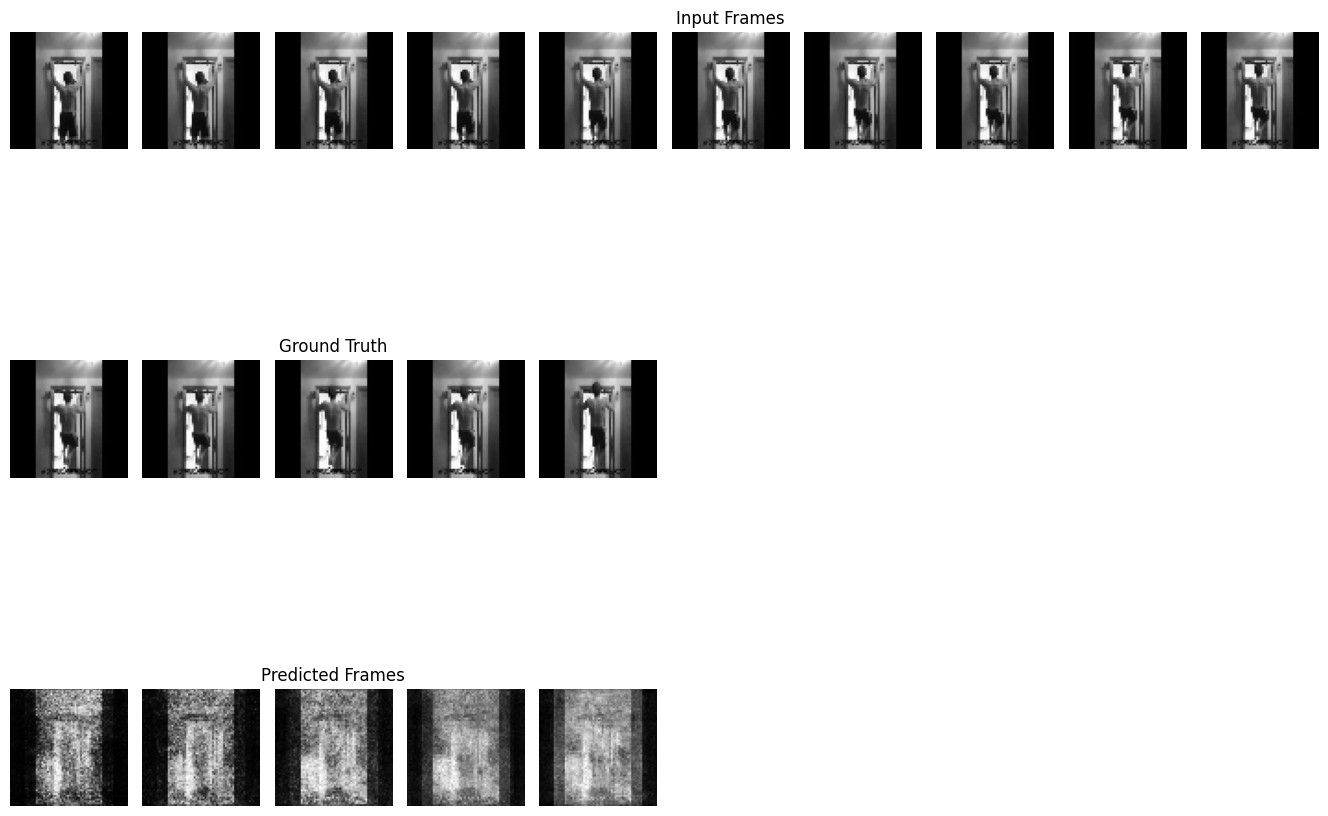

Evaluating model SSIM for Vision Transformer...


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Average SSIM across the test set: 0.0738
Evaluating model SSIM for Vision Transformer...
Average SSIM across the test set: 0.0664


In [12]:
# Visualize Predictions
print("Visualizing Vision Transformer predictions...")
visualize_vit_predictions(
    model=model,
    test_gen_viz=test_gen_viz,
    input_frames=input_frames,
    output_frames=output_frames,
    batch_size=1
)



test_gen = DataGenerator(
    preprocessed_dir=preprocessed_test_dir,
    input_frames=input_frames,
    output_frames=output_frames,
    batch_size=batch_size
)

# Evaluate Model Performance
print("Evaluating model SSIM for Vision Transformer...")
average_ssim = evaluate_vit_ssim(model, test_gen, input_frames, output_frames)

# Evaluate Model Performance
print("Evaluating model SSIM for Vision Transformer...")
average_ssim = evaluate_vit_ssim(model, test_gen, input_frames, output_frames)
